<a href="https://colab.research.google.com/github/fitzwolf/DL4HGPTProject/blob/main/DL4HFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


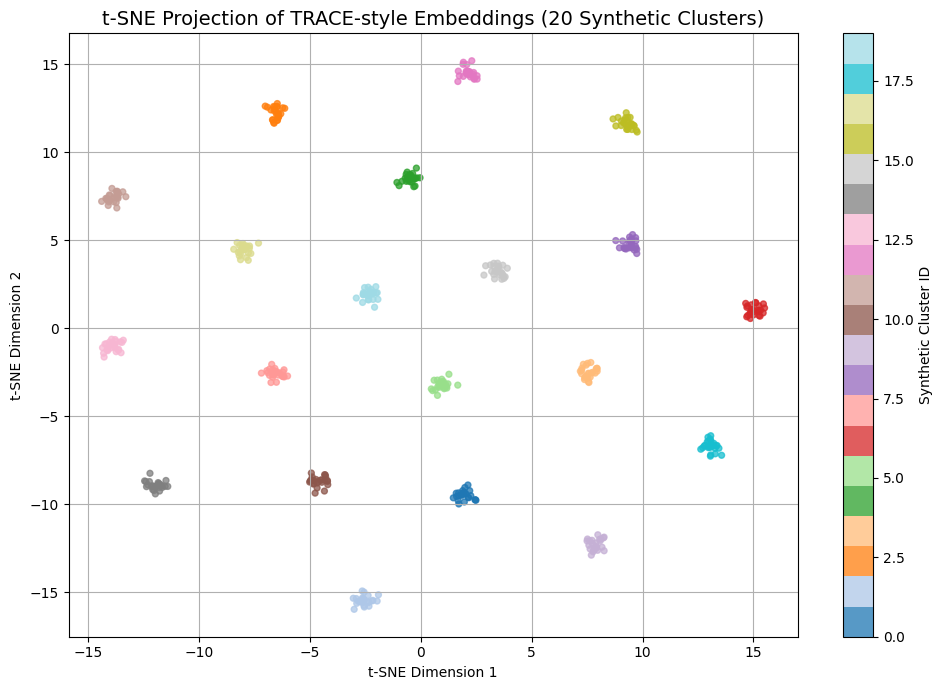

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# Reducing parameters for faster execution
X, y = make_blobs(n_samples=500, centers=20, n_features=32, cluster_std=2.0, random_state=42)
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

# Save t-SNE plot
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab20', alpha=0.75, s=18)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Synthetic Cluster ID')
ax.set_title('t-SNE Projection of TRACE-style Embeddings (20 Synthetic Clusters)', fontsize=14)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.grid(True)
plt.tight_layout()

# image_path = "/mnt/data/tsne_trace_20_clusters_v2.png"
# plt.savefig(image_path, dpi=300)
# image_path


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Core Functions ---
# Simulates a single synthetic ICU patient with realistic signal behavior.
# Can simulate healthy, shock, or respiratory failure states.
# Optionally returns a label (0=healthy, 1=shock, 2=respiratory failure).
# Inputs seed: seed value for reproducibility
#        out_label: Bool for whether to include out labels.
def simulate_hirid_patient_realistic_with_labels(seed=None, out_label=False):
    if seed is not None:
        np.random.seed(seed)

    # Generate patient stay duration between 1 and 14 days at 5-minute resolution
    duration_days = np.random.randint(1, 15)
    timesteps = duration_days * 24 * 12  # 5-min intervals
    time_index = np.arange(0, timesteps * 5, 5)

    # --- Signal Initialization ---
    heart_rate = np.random.normal(80, 10, timesteps)
    map_pressure = np.random.normal(75, 8, timesteps)
    respiratory_rate = np.random.normal(18, 3, timesteps)
    spo2 = np.random.normal(97, 2, timesteps)
    temperature = np.random.normal(37.0, 0.5, timesteps)
    lactate = np.random.normal(1.2, 0.4, timesteps)
    creatinine = np.random.normal(1.0, 0.3, timesteps)
    glucose = np.random.normal(110, 20, timesteps)
    vasopressor_rate = np.zeros(timesteps)
    mech_ventilation = np.zeros(timesteps)

    label = 0  # Default to healthy (0)

    # --- Insert Shock Event --- 40% chance
    if np.random.rand() < 0.4:
        shock_start = np.random.randint(timesteps // 4, timesteps // 2)
        shock_duration = np.random.randint(100, 500)
        if shock_start + shock_duration > timesteps:
            shock_duration = timesteps - shock_start
        if shock_duration > 0:
            heart_rate[shock_start:shock_start+shock_duration] += np.random.normal(10, 3, shock_duration)
            map_pressure[shock_start:shock_start+shock_duration] -= np.random.normal(10, 3, shock_duration)
            lactate[shock_start:shock_start+shock_duration] += np.random.normal(2, 0.5, shock_duration)
            vasopressor_rate[shock_start:shock_start+shock_duration] = np.random.uniform(0.05, 0.2)
            label = 1  # Shock

    # --- Insert Respiratory Failure --- 40% chance
    if np.random.rand() < 0.4:
        if timesteps > 1000:
            resp_failure_start = np.random.randint(timesteps // 2, timesteps - 500)
            resp_failure_duration = np.random.randint(100, 400)
            if resp_failure_start + resp_failure_duration > timesteps:
                resp_failure_duration = timesteps - resp_failure_start
            if resp_failure_duration > 0:
                spo2[resp_failure_start:resp_failure_start+resp_failure_duration] -= np.random.normal(10, 3, resp_failure_duration)
                respiratory_rate[resp_failure_start:resp_failure_start+resp_failure_duration] += np.random.normal(5, 2, resp_failure_duration)
                mech_ventilation[resp_failure_start:resp_failure_start+resp_failure_duration] = 1
                label = 2  # Respiratory Failure

    # --- Mild Drift ---
    drift = np.cumsum(np.random.normal(0, 0.01, timesteps))
    heart_rate += drift
    map_pressure += np.random.normal(0, 0.5, timesteps)
    respiratory_rate += np.random.normal(0, 0.5, timesteps)

    # --- Clamp to Realistic Ranges ---
    heart_rate = np.clip(heart_rate, 30, 200).astype(int)
    map_pressure = np.clip(map_pressure, 30, 130).astype(int)
    respiratory_rate = np.clip(respiratory_rate, 5, 50).astype(int)
    spo2 = np.clip(spo2, 70, 100).astype(int)
    temperature = np.clip(temperature, 35.0, 41.0)
    lactate = np.clip(lactate, 0.5, 15.0)
    creatinine = np.clip(creatinine, 0.2, 5.0)
    glucose = np.clip(glucose, 40, 400).astype(int)
    vasopressor_rate = np.round(vasopressor_rate, 3)
    mech_ventilation = mech_ventilation.astype(int)

    patient = np.stack([
        heart_rate,
        map_pressure,
        respiratory_rate,
        spo2,
        temperature,
        lactate,
        creatinine,
        glucose,
        vasopressor_rate,
        mech_ventilation
    ], axis=0)

    # --- Add Missingness ---
    missing_rate = np.random.uniform(0.05, 0.15)
    missing_mask = np.random.rand(*patient.shape) < missing_rate
    patient[missing_mask] = 0

    if np.random.rand() < 0.1:
        for _ in range(np.random.randint(1, 3)):
            block_signal = np.random.randint(0, patient.shape[0])
            block_start = np.random.randint(0, max(1, patient.shape[1] - 200))
            block_length = np.random.randint(50, 200)
            patient[block_signal, block_start:block_start+block_length] = 0

    if out_label:
        return patient, label
    else:
        return patient

# --- New Helper Function: Longevity Score
# Heuristic "longevity score" estimator based on vitals.
# Higher average vitals stability → higher score.
# Adds small Gaussian noise to introduce variability.

def simulate_longevity_score(patient_signal):
    """
    Proxy: higher vitals stability → longer survival.
    """
    mean_vitals = np.mean(np.abs(patient_signal[0:4, :]))
    noise = np.random.normal(0, 0.1)
    score = mean_vitals + noise
    return score

# --- Updated Dataset Generation Function
# Generates a full batch of synthetic ICU patients and saves data to disk.
# Includes both "health condition" labels and synthetic "longevity" binary labels.

def simulate_hirid_dataset(save_dir, num_runs=10, patients_per_run=1000):
    os.makedirs(save_dir, exist_ok=True)

    for run_idx in range(num_runs):
        print(f'Generating run {run_idx+1}/{num_runs}...')
        patients = []
        health_labels = []
        longevity_scores = []

        for _ in tqdm(range(patients_per_run)):
            patient, health_label = simulate_hirid_patient_realistic_with_labels(out_label=True)
            patients.append(patient)
            health_labels.append(health_label)
            longevity_scores.append(simulate_longevity_score(patient))

        max_length = max([p.shape[1] for p in patients])

        padded_patients = []
        for patient in patients:
            pad_width = max_length - patient.shape[1]
            if pad_width > 0:
                padded_patient = np.pad(patient, ((0,0), (0,pad_width)), 'constant')
            else:
                padded_patient = patient
            padded_patients.append(padded_patient)

        X_run = np.stack(padded_patients)
        y_run = np.array(health_labels)
        longevity_scores = np.array(longevity_scores)

        # Create Longevity Labels
        threshold = np.median(longevity_scores)
        longevity_labels = (longevity_scores > threshold).astype(int)

        run_folder = os.path.join(save_dir, f'run_{run_idx}')
        os.makedirs(run_folder, exist_ok=True)
        np.save(os.path.join(run_folder, 'X.npy'), X_run)
        np.save(os.path.join(run_folder, 'y.npy'), y_run)
        np.save(os.path.join(run_folder, 'longevity_labels.npy'), longevity_labels)

        print(f'Saved run {run_idx}: X shape {X_run.shape}, y shape {y_run.shape}, longevity labels shape {longevity_labels.shape}')




In [3]:
def load_synthetic_batches(base_path, runs_to_load=None):
    """
    base_path: path where all runs are saved
    runs_to_load: list of run indices [0, 1, 2] to load, None = load all
    """
    if runs_to_load is None:
        runs_to_load = [int(d.split('_')[1]) for d in os.listdir(base_path) if d.startswith('run_')]

    all_X = []

    for run_idx in runs_to_load:
        run_folder = os.path.join(base_path, f'run_{run_idx}')
        print(f'Loading run {run_idx} from {run_folder}')
        X_batch = np.load(os.path.join(run_folder, 'X.npy'))
        all_X.append(X_batch)

    X_full = np.concatenate(all_X, axis=0)
    print(f'Total shape after loading: {X_full.shape}')
    return X_full

In [4]:
# This connects to your google drive to allow saving of
# multiple runs because of memory constraints w/ colab free
# This will also allow fo saving of the runs for manual inspection
# if needed for debugging.

from google.colab import drive
drive.mount('/content/drive')

# Generate 10x1000 synthetic ICU patients
simulate_hirid_dataset('/content/drive/MyDrive/TRACE_SYNTHETIC_FULL/', num_runs=10, patients_per_run=1000)

# Later: Load first 2 runs
X_data = load_synthetic_batches('/content/drive/MyDrive/TRACE_SYNTHETIC_FULL/', runs_to_load=[3,4])

print(X_data.shape)  # Should be (2000, 10, max_timesteps)

Mounted at /content/drive
Generating run 1/10...


100%|██████████| 1000/1000 [00:03<00:00, 311.30it/s]


Saved run 0: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 2/10...


100%|██████████| 1000/1000 [00:01<00:00, 500.42it/s]


Saved run 1: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 3/10...


100%|██████████| 1000/1000 [00:01<00:00, 586.97it/s]


Saved run 2: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 4/10...


100%|██████████| 1000/1000 [00:01<00:00, 576.12it/s]


Saved run 3: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 5/10...


100%|██████████| 1000/1000 [00:01<00:00, 613.67it/s]


Saved run 4: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 6/10...


100%|██████████| 1000/1000 [00:02<00:00, 450.47it/s]


Saved run 5: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 7/10...


100%|██████████| 1000/1000 [00:02<00:00, 433.50it/s]


Saved run 6: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 8/10...


100%|██████████| 1000/1000 [00:01<00:00, 600.36it/s]


Saved run 7: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 9/10...


100%|██████████| 1000/1000 [00:01<00:00, 525.98it/s]


Saved run 8: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Generating run 10/10...


100%|██████████| 1000/1000 [00:01<00:00, 600.75it/s]


Saved run 9: X shape (1000, 10, 4032), y shape (1000,), longevity labels shape (1000,)
Loading run 3 from /content/drive/MyDrive/TRACE_SYNTHETIC_FULL/run_3
Loading run 4 from /content/drive/MyDrive/TRACE_SYNTHETIC_FULL/run_4
Total shape after loading: (2000, 10, 4032)
(2000, 10, 4032)


In [5]:
# imports needed for data recreation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [6]:
# This function will simulate ICU data based on what the hirid
# data looks like, it also adds labels based on the paper
# (BibiTex format)
# title = 	 {Learning Unsupervised Representations for ICU Timeseries},
# author =       {Weatherhead, Addison and Greer, Robert and Moga, Michael-Alice and Mazwi, Mjaye and Eytan, Danny and Goldenberg, Anna and Tonekaboni, Sana},
# booktitle = 	 {Proceedings of the Conference on Health, Inference, and Learning},
# pages = 	 {152--168},
# year = 	 {2022},
# editor = 	 {Flores, Gerardo and Chen, George H and Pollard, Tom and Ho, Joyce C and Naumann, Tristan},
# volume = 	 {174},
# series = 	 {Proceedings of Machine Learning Research},
# month = 	 {07--08 Apr},
# publisher =    {PMLR},
# pdf = 	 {https://proceedings.mlr.press/v174/weatherhead22a/weatherhead22a.pdf},
# url = 	 {https://proceedings.mlr.press/v174/weatherhead22a.html},
# abstract = 	 {Medical time series like physiological signals provide a rich source of information about patients’ underlying clinical states. Learning such states is a challenging problem for ML but has great utility for clinical applications. It allows us to identify patients with similar underlying conditions, track disease progression over time, and much more. The challenge with medical time series however, is the lack of well-defined labels for a given patient’s state for extended periods of time. Collecting such labels is expensive and often requires substantial effort. In this work, we propose an unsupervised representation learning method, called TRACE, that allows us to learn meaningful patient representations from time series collected in the Intensive Care Unit (ICU). We show the utility and generalizability of these representations in identifying different downstream clinical conditions and also show how the trajectory of representations over time exhibits progression toward critical conditions such as cardiopulmonary arrest or circulatory failure.}

def simulate_hirid_patient_realistic_with_labels(seed=None, out_label=False):
    if seed is not None:
        np.random.seed(seed)

    duration_days = np.random.randint(1, 15)
    timesteps = duration_days * 24 * 12  # 5-min intervals
    time_index = np.arange(0, timesteps * 5, 5)

    heart_rate = np.random.normal(80, 10, timesteps)
    map_pressure = np.random.normal(75, 8, timesteps)
    respiratory_rate = np.random.normal(18, 3, timesteps)
    spo2 = np.random.normal(97, 2, timesteps)
    temperature = np.random.normal(37.0, 0.5, timesteps)
    lactate = np.random.normal(1.2, 0.4, timesteps)
    creatinine = np.random.normal(1.0, 0.3, timesteps)
    glucose = np.random.normal(110, 20, timesteps)
    vasopressor_rate = np.zeros(timesteps)
    mech_ventilation = np.zeros(timesteps)

    label = 0  # 0 = healthy

    # Shock
    shock_start = np.random.randint(timesteps // 4, timesteps // 2)
    shock_duration = np.random.randint(100, 500)
    if shock_start + shock_duration > timesteps:
        shock_duration = timesteps - shock_start
    if shock_duration > 0:
        heart_rate[shock_start:shock_start+shock_duration] += np.random.normal(10, 3, shock_duration)
        map_pressure[shock_start:shock_start+shock_duration] -= np.random.normal(10, 3, shock_duration)
        lactate[shock_start:shock_start+shock_duration] += np.random.normal(2, 0.5, shock_duration)
        vasopressor_rate[shock_start:shock_start+shock_duration] = np.random.uniform(0.05, 0.2)
        label = 1

    # Resp Failure
    if np.random.rand() < 0.5 and timesteps > 1000:
        resp_failure_start = np.random.randint(timesteps // 2, timesteps - 500)
        resp_failure_duration = np.random.randint(100, 400)
        if resp_failure_start + resp_failure_duration > timesteps:
            resp_failure_duration = timesteps - resp_failure_start
        if resp_failure_duration > 0:
            spo2[resp_failure_start:resp_failure_start+resp_failure_duration] -= np.random.normal(10, 3, resp_failure_duration)
            respiratory_rate[resp_failure_start:resp_failure_start+resp_failure_duration] += np.random.normal(5, 2, resp_failure_duration)
            mech_ventilation[resp_failure_start:resp_failure_start+resp_failure_duration] = 1
            label = 2  # Overwrite label if respiratory failure present

    drift = np.cumsum(np.random.normal(0, 0.01, timesteps))
    heart_rate += drift
    map_pressure += np.random.normal(0, 0.5, timesteps)
    respiratory_rate += np.random.normal(0, 0.5, timesteps)

    heart_rate = np.clip(heart_rate, 30, 200).astype(int)
    map_pressure = np.clip(map_pressure, 30, 130).astype(int)
    respiratory_rate = np.clip(respiratory_rate, 5, 50).astype(int)
    spo2 = np.clip(spo2, 70, 100).astype(int)
    temperature = np.clip(temperature, 35.0, 41.0)
    lactate = np.clip(lactate, 0.5, 15.0)
    creatinine = np.clip(creatinine, 0.2, 5.0)
    glucose = np.clip(glucose, 40, 400).astype(int)

    vasopressor_rate = np.round(vasopressor_rate, 3)
    mech_ventilation = mech_ventilation.astype(int)

    patient = np.stack([
        heart_rate,
        map_pressure,
        respiratory_rate,
        spo2,
        temperature,
        lactate,
        creatinine,
        glucose,
        vasopressor_rate,
        mech_ventilation
    ], axis=0)

    # Add missingness
    missing_rate = np.random.uniform(0.05, 0.15)
    missing_mask = np.random.rand(*patient.shape) < missing_rate
    patient[missing_mask] = 0

    if np.random.rand() < 0.1:
        for _ in range(np.random.randint(1, 3)):
            block_signal = np.random.randint(0, patient.shape[0])
            block_start = np.random.randint(0, max(1, patient.shape[1] - 200))
            block_length = np.random.randint(50, 200)
            patient[block_signal, block_start:block_start+block_length] = 0

    if out_label:
        return patient, label
    else:
        return patient


In [7]:
# This function allows for simulation of multiple runs of one of the
# above simulators - for now to swap you need to change the code
# line patient, label = simulate_hirid_patient_realistic_with_labels(out_label=True)
# to reflect which simulator you need
# Inputs: save_dir: directory to save the runs
#         num_runs: how many runs you want to create
#         patients_per_run: how many patients each run generates
def simulate_hirid_dataset(save_dir, num_runs=1, patients_per_run=1000):
    os.makedirs(save_dir, exist_ok=True)

    for run_idx in range(num_runs):
        print(f'Generating run {run_idx+1}/{num_runs}...')
        patients = []
        labels = []

        for _ in tqdm(range(patients_per_run)):
            patient, label = simulate_hirid_patient_realistic_with_labels(out_label=True)
            patients.append(patient)
            labels.append(label)

        max_length = max([p.shape[1] for p in patients])

        padded_patients = []
        for patient in patients:
            pad_width = max_length - patient.shape[1]
            padded_patient = np.pad(patient, ((0, 0), (0, pad_width)), 'constant')
            padded_patients.append(padded_patient)

        X_run = np.stack(padded_patients)
        y_run = np.array(labels)

        run_folder = os.path.join(save_dir, f'run_{run_idx}')
        os.makedirs(run_folder, exist_ok=True)
        np.save(os.path.join(run_folder, 'X.npy'), X_run)
        np.save(os.path.join(run_folder, 'y.npy'), y_run)
        print(f'Saved run {run_idx}: X shape {X_run.shape}, y shape {y_run.shape}')


In [8]:
# A PyTorch Dataset class for loading synthetic ICU data
# Expects numpy files `X.npy` (time series) and `y.npy` (labels) in a given folder.
# Converts the data to PyTorch tensors for use with DataLoader.

class RichSyntheticICUDataset(Dataset):
    def __init__(self, data_folder):
        self.X = np.load(os.path.join(data_folder, 'X.npy'))
        self.y = np.load(os.path.join(data_folder, 'y.npy'))
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [9]:
# This is a self-supervised TRACE-style encoder model.
# It takes masked time series input and learns a compressed latent vector
# from which it reconstructs a summary target (channel-wise mean values).

class TRACEEncoderMasked(nn.Module):
    def __init__(self, input_channels=10, latent_dim=128):
        super(TRACEEncoderMasked, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_channels)
        )

    def forward(self, x, mask=None):
        x_input = x.clone()
        if mask is not None:
            x_input = x_input * mask
        encoded = self.encoder(x_input)
        encoded = encoded.squeeze(-1)
        latent = self.fc(encoded)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

def generate_random_mask(batch_shape, mask_ratio=0.15):
    batch_size, channels, timesteps = batch_shape
    mask = torch.ones(batch_size, channels, timesteps)
    num_total = channels * timesteps
    num_mask = int(mask_ratio * num_total)
    for b in range(batch_size):
        idx = torch.randperm(num_total)[:num_mask]
        coords = np.unravel_index(idx.numpy(), (channels, timesteps))
        mask[b, coords[0], coords[1]] = 0
    return mask

def masked_mse_loss(y_pred, y_true, mask):
    mask = (mask.sum(dim=2) > 0).float()
    loss = (mask * (y_pred - y_true)**2).sum() / (mask.sum() + 1e-6)
    return loss

def train_trace_masked_model(model, train_loader, num_epochs=20, lr=0.001, mask_ratio=0.15, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        count_batches = 0
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            mask = generate_random_mask(X_batch.shape, mask_ratio=mask_ratio).to(device)
            reconstructed, _ = model(X_batch, mask)
            X_target = X_batch.mean(dim=2)
            loss = masked_mse_loss(reconstructed, X_target, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count_batches += 1
        avg_loss = total_loss / count_batches
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.6f}')
    print('Training finished!')
    return model


In [10]:
def extract_embeddings_and_labels(model, data_loader, device='cuda'):
    model = model.to(device)
    model.eval()

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            _, latent = model(X_batch, mask=None)  # no masking during inference
            all_embeddings.append(latent.cpu().numpy())
            all_labels.append(y_batch.numpy())

    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.concatenate(all_labels)

    print(f'Embeddings shape: {all_embeddings.shape}')
    print(f'Labels shape: {all_labels.shape}')

    return all_embeddings, all_labels


In [11]:
def plot_tsne(embeddings, labels=None):
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings_scaled)

    plt.figure(figsize=(10, 8))

    if labels is not None:
        unique_labels = np.unique(labels)
        colors = ['blue', 'red', 'green', 'purple', 'orange']
        for idx, label in enumerate(unique_labels):
            mask = labels == label
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=f'Label {label}', alpha=0.6, s=10, c=colors[idx % len(colors)])
        plt.legend()
    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=10)

    plt.title('t-SNE Projection of TRACE Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()


In [12]:
def simple_classifier_experiments(embeddings, labels, num_classes=3):
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42, stratify=labels)

    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5)
    }

    results = {}

    for name, clf in classifiers.items():
        print(f'\nTraining {name}...')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {acc:.4f}')
        print('Confusion Matrix:')
        print(confusion_matrix(y_test, y_pred))
        print('Classification Report:')
        print(classification_report(y_test, y_pred))

        results[name] = acc

    print('\n=== Summary of Classifier Accuracies ===')
    for name, acc in results.items():
        print(f'{name}: {acc:.4f}')


In [13]:
# Assuming you have already generated a run like 'run_0'
data_path = '/content/drive/MyDrive/TRACE_SYNTHETIC_FULL/run_0/'

# Load the dataset
dataset = RichSyntheticICUDataset(data_path)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create the model
input_channels = 10  # heart rate, map, etc
latent_dim = 128     # same as before
model = TRACEEncoderMasked(input_channels=input_channels, latent_dim=latent_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train TRACE with masked modeling
trained_model = train_trace_masked_model(model, train_loader, num_epochs=20, lr=0.001, mask_ratio=0.15, device=device)


Epoch [1/20] Loss: 160.644163
Epoch [2/20] Loss: 3.181330
Epoch [3/20] Loss: 0.348295
Epoch [4/20] Loss: 0.218765
Epoch [5/20] Loss: 0.224497
Epoch [6/20] Loss: 0.225590
Epoch [7/20] Loss: 0.216705
Epoch [8/20] Loss: 0.220012
Epoch [9/20] Loss: 0.225163
Epoch [10/20] Loss: 0.221198
Epoch [11/20] Loss: 0.194695
Epoch [12/20] Loss: 0.189132
Epoch [13/20] Loss: 0.195180
Epoch [14/20] Loss: 0.196502
Epoch [15/20] Loss: 0.194905
Epoch [16/20] Loss: 0.185807
Epoch [17/20] Loss: 0.170887
Epoch [18/20] Loss: 0.184036
Epoch [19/20] Loss: 0.174944
Epoch [20/20] Loss: 0.177068
Training finished!


Embeddings shape: (1000, 128)
Labels shape: (1000,)


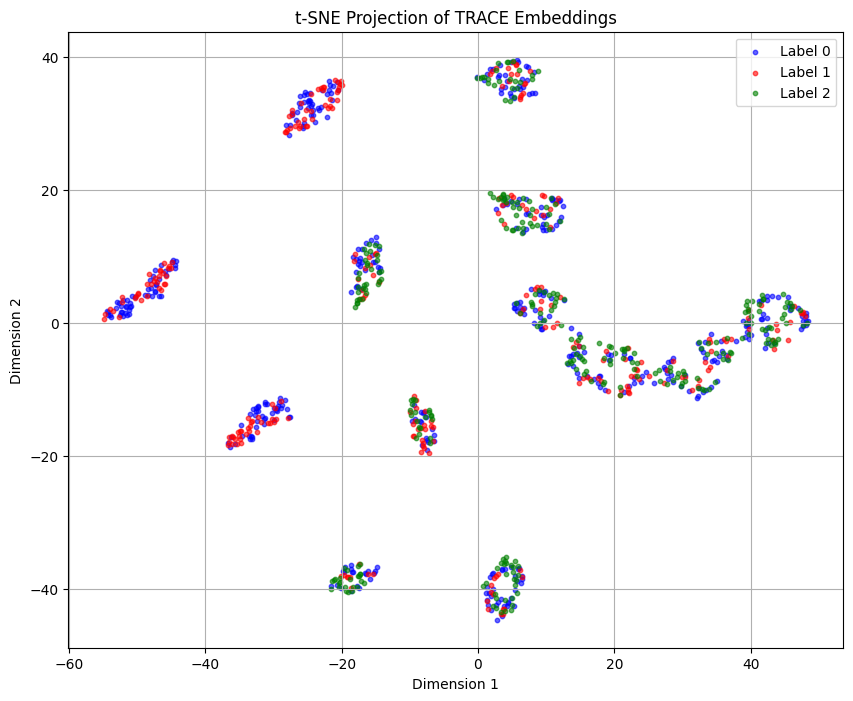


Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6833
Confusion Matrix:
[[96  7 25]
 [22 52  8]
 [24  9 57]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       128
           1       0.76      0.63      0.69        82
           2       0.63      0.63      0.63        90

    accuracy                           0.68       300
   macro avg       0.69      0.67      0.68       300
weighted avg       0.69      0.68      0.68       300


Training Random Forest...
Accuracy: 0.5700
Confusion Matrix:
[[86 14 28]
 [30 35 17]
 [33  7 50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       128
           1       0.62      0.43      0.51        82
           2       0.53      0.56      0.54        90

    accuracy                           0.57       300
   macro avg       0.58      0.55      0.56       300
weighted avg       0.57      0.57      0.57       300


Training k-NN (k=5).

In [14]:
# (after model is trained)

# Step 1: Extract embeddings + labels
embeddings, labels = extract_embeddings_and_labels(trained_model, train_loader, device=device)

# Step 2: t-SNE plot
plot_tsne(embeddings, labels=labels)

# Step 3: Classifier experiments
simple_classifier_experiments(embeddings, labels, num_classes=3)


In [15]:
def flatten_raw_timeseries(dataset):
    """
    dataset: RichSyntheticICUDataset (or similar)

    Returns:
    - flattened_X: (num_patients, channels * timesteps)
    - labels: (num_patients,)
    """
    X = dataset.X.numpy()  # shape (patients, channels, timesteps)
    y = dataset.y.numpy()  # shape (patients,)

    num_patients, num_channels, num_timesteps = X.shape
    flattened_X = X.reshape(num_patients, num_channels * num_timesteps)

    return flattened_X, y


In [16]:
def raw_signal_classifier_experiments(flattened_X, labels, num_classes=3):
    X_train, X_test, y_train, y_test = train_test_split(
        flattened_X, labels, test_size=0.3, random_state=42, stratify=labels
    )

    classifiers = {
        'Logistic Regression (Raw)': LogisticRegression(max_iter=1000),
        'Random Forest (Raw)': RandomForestClassifier(n_estimators=100),
        'k-NN (Raw) (k=5)': KNeighborsClassifier(n_neighbors=5)
    }

    results = {}

    for name, clf in classifiers.items():
        print(f'\nTraining {name}...')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {acc:.4f}')
        print('Confusion Matrix:')
        print(confusion_matrix(y_test, y_pred))
        print('Classification Report:')
        print(classification_report(y_test, y_pred))

        results[name] = acc

    print('\n=== Summary of Raw Classifier Accuracies ===')
    for name, acc in results.items():
        print(f'{name}: {acc:.4f}')


In [17]:
# Step 1: Flatten raw timeseries
flattened_X, raw_labels = flatten_raw_timeseries(dataset)

# Step 2: Run classifiers
raw_signal_classifier_experiments(flattened_X, raw_labels, num_classes=3)



Training Logistic Regression (Raw)...
Accuracy: 0.4500
Confusion Matrix:
[[70 10 48]
 [29 28 25]
 [33 20 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.55      0.54       128
           1       0.48      0.34      0.40        82
           2       0.34      0.41      0.37        90

    accuracy                           0.45       300
   macro avg       0.45      0.43      0.44       300
weighted avg       0.46      0.45      0.45       300


Training Random Forest (Raw)...
Accuracy: 0.8567
Confusion Matrix:
[[128   0   0]
 [ 10  65   7]
 [ 18   8  64]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       128
           1       0.89      0.79      0.84        82
           2       0.90      0.71      0.80        90

    accuracy                           0.86       300
   macro avg       0.87      0.83      0.85       300
weighted avg       0.8

In [18]:
def small_random_forest_test(flattened_X, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        flattened_X, labels, test_size=0.3, random_state=42, stratify=labels
    )

    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy with 10 trees: {acc:.4f}')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))


In [19]:
def add_gaussian_noise(flattened_X, noise_std=0.05):
    noise = np.random.normal(0, noise_std, size=flattened_X.shape)
    noisy_X = flattened_X + noise
    return noisy_X


In [20]:
def random_feature_dropout(flattened_X, drop_rate=0.1):
    X_copy = flattened_X.copy()
    num_features = X_copy.shape[1]
    num_drop = int(num_features * drop_rate)
    drop_indices = np.random.choice(num_features, size=num_drop, replace=False)
    X_copy[:, drop_indices] = 0
    return X_copy


In [21]:
flattened_X, raw_labels = flatten_raw_timeseries(dataset)

small_random_forest_test(flattened_X, raw_labels)


Accuracy with 10 trees: 0.7833
Confusion Matrix:
[[123   0   5]
 [ 14  60   8]
 [ 24  14  52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       128
           1       0.81      0.73      0.77        82
           2       0.80      0.58      0.67        90

    accuracy                           0.78       300
   macro avg       0.79      0.76      0.76       300
weighted avg       0.79      0.78      0.77       300



In [22]:
noisy_X = add_gaussian_noise(flattened_X, noise_std=0.1)

small_random_forest_test(noisy_X, raw_labels)


Accuracy with 10 trees: 0.7100
Confusion Matrix:
[[114   5   9]
 [ 22  48  12]
 [ 27  12  51]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       128
           1       0.74      0.59      0.65        82
           2       0.71      0.57      0.63        90

    accuracy                           0.71       300
   macro avg       0.72      0.68      0.69       300
weighted avg       0.71      0.71      0.70       300



In [23]:
dropped_X = random_feature_dropout(flattened_X, drop_rate=0.1)

small_random_forest_test(dropped_X, raw_labels)


Accuracy with 10 trees: 0.7633
Confusion Matrix:
[[118   2   8]
 [ 14  62   6]
 [ 28  13  49]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       128
           1       0.81      0.76      0.78        82
           2       0.78      0.54      0.64        90

    accuracy                           0.76       300
   macro avg       0.77      0.74      0.75       300
weighted avg       0.77      0.76      0.75       300



In [24]:
def create_fake_transfer_labels(labels, num_new_classes=3):
    """
    Creates a new random set of labels for transfer learning simulation.
    """
    np.random.seed(42)
    new_labels = np.random.randint(0, num_new_classes, size=len(labels))
    return new_labels


In [25]:
class TransferClassifier(nn.Module):
    def __init__(self, encoder, latent_dim=128, num_classes=3):
        super(TransferClassifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            latent = self.encoder.encoder(x)  # Only encoder feature extractor
            latent = latent.squeeze(-1)
            latent = self.encoder.fc(latent)
        out = self.fc(latent)
        return out


In [26]:
def train_transfer_classifier(model, train_loader, new_labels, num_epochs=20, lr=0.001, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model = model.to(device)
    model.train()

    all_labels = torch.tensor(new_labels, dtype=torch.long)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        idx = 0

        for X_batch, _ in train_loader:
            batch_size = X_batch.size(0)
            y_batch = all_labels[idx:idx+batch_size]
            idx += batch_size

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}%')

    print('Finished Transfer Training!')


In [27]:
# Step 1: Extract embeddings and labels
embeddings, labels = extract_embeddings_and_labels(trained_model, train_loader, device=device)

# Step 2: Create new fake task
new_transfer_labels = create_fake_transfer_labels(labels, num_new_classes=3)

# Step 3: Setup transfer classifier
transfer_model = TransferClassifier(trained_model, latent_dim=128, num_classes=3)

# Step 4: Train
train_transfer_classifier(transfer_model, train_loader, new_transfer_labels, num_epochs=20, lr=0.001, device=device)


Embeddings shape: (1000, 128)
Labels shape: (1000,)
Epoch [1/20] Loss: 1.3094 Accuracy: 35.10%
Epoch [2/20] Loss: 1.1499 Accuracy: 33.50%
Epoch [3/20] Loss: 1.1456 Accuracy: 35.10%
Epoch [4/20] Loss: 1.1504 Accuracy: 32.50%
Epoch [5/20] Loss: 1.1376 Accuracy: 33.10%
Epoch [6/20] Loss: 1.1445 Accuracy: 33.50%
Epoch [7/20] Loss: 1.1832 Accuracy: 34.20%
Epoch [8/20] Loss: 1.1311 Accuracy: 33.60%
Epoch [9/20] Loss: 1.1581 Accuracy: 31.80%
Epoch [10/20] Loss: 1.1531 Accuracy: 32.40%
Epoch [11/20] Loss: 1.1688 Accuracy: 32.70%
Epoch [12/20] Loss: 1.1746 Accuracy: 33.10%
Epoch [13/20] Loss: 1.1947 Accuracy: 32.00%
Epoch [14/20] Loss: 1.1750 Accuracy: 32.90%
Epoch [15/20] Loss: 1.1677 Accuracy: 32.50%
Epoch [16/20] Loss: 1.1647 Accuracy: 32.40%
Epoch [17/20] Loss: 1.1524 Accuracy: 33.60%
Epoch [18/20] Loss: 1.1628 Accuracy: 35.70%
Epoch [19/20] Loss: 1.1489 Accuracy: 33.80%
Epoch [20/20] Loss: 1.1424 Accuracy: 32.70%
Finished Transfer Training!


In [28]:
# ==========================
# Longevity Transfer Learning Experiment
# ==========================

# Step 1: Load Data
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

# Path where your run is stored
data_path = '/content/drive/MyDrive/TRACE_SYNTHETIC_FULL/run_0/'  # Change if needed!

# Load
X = np.load(data_path + 'X.npy')  # (patients, channels, timesteps)
longevity_labels = np.load(data_path + 'longevity_labels.npy')  # (patients,)

print(f'Data Loaded: X.shape={X.shape}, longevity_labels.shape={longevity_labels.shape}')

# Step 2: Build Dataset and DataLoader
class LongevityDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

longevity_dataset = LongevityDataset(X, longevity_labels)
longevity_loader = DataLoader(longevity_dataset, batch_size=32, shuffle=True)

# Step 3: Build Transfer Classifier (Freeze Encoder)
class TransferClassifier(nn.Module):
    def __init__(self, encoder, latent_dim=128, num_classes=2):
        super(TransferClassifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            latent = self.encoder.encoder(x)  # Use TRACE encoder part
            latent = latent.squeeze(-1)
            latent = self.encoder.fc(latent)
        out = self.fc(latent)
        return out

# Step 4: Setup Transfer Classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transfer_model = TransferClassifier(trained_model, latent_dim=128, num_classes=2).to(device)

# Step 5: Fine-Tune on Longevity Labels
def train_transfer_classifier(model, loader, labels, num_epochs=20, lr=0.001, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    labels = torch.tensor(labels, dtype=torch.long)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        idx = 0

        for X_batch, _ in loader:
            batch_size = X_batch.size(0)
            y_batch = labels[idx:idx+batch_size]
            idx += batch_size

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        epoch_loss = running_loss / len(loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}%')

    print('Finished Longevity Transfer Training!')

# Step 6: Launch Training
train_transfer_classifier(transfer_model, longevity_loader, longevity_labels, num_epochs=20, lr=0.001, device=device)


Data Loaded: X.shape=(1000, 10, 4032), longevity_labels.shape=(1000,)
Epoch [1/20] Loss: 0.9668 Accuracy: 47.60%
Epoch [2/20] Loss: 0.7674 Accuracy: 48.60%
Epoch [3/20] Loss: 0.7098 Accuracy: 50.70%
Epoch [4/20] Loss: 0.7360 Accuracy: 49.00%
Epoch [5/20] Loss: 0.7414 Accuracy: 47.50%
Epoch [6/20] Loss: 0.7770 Accuracy: 51.10%
Epoch [7/20] Loss: 0.7240 Accuracy: 47.30%
Epoch [8/20] Loss: 0.7659 Accuracy: 49.40%
Epoch [9/20] Loss: 0.7646 Accuracy: 48.80%
Epoch [10/20] Loss: 0.7591 Accuracy: 49.90%
Epoch [11/20] Loss: 0.7564 Accuracy: 49.30%
Epoch [12/20] Loss: 0.7131 Accuracy: 49.50%
Epoch [13/20] Loss: 0.7686 Accuracy: 47.90%
Epoch [14/20] Loss: 0.7745 Accuracy: 48.30%
Epoch [15/20] Loss: 0.8229 Accuracy: 50.10%
Epoch [16/20] Loss: 0.7261 Accuracy: 49.40%
Epoch [17/20] Loss: 0.7061 Accuracy: 49.80%
Epoch [18/20] Loss: 0.7424 Accuracy: 49.00%
Epoch [19/20] Loss: 0.7512 Accuracy: 48.60%
Epoch [20/20] Loss: 0.7315 Accuracy: 50.00%
Finished Longevity Transfer Training!


In [29]:
# ==========================
# Longevity Transfer Learning Evaluation
# ==========================

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Switch to eval mode
transfer_model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in longevity_loader:
        X_batch = X_batch.to(device)
        outputs = transfer_model(X_batch)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(y_batch.numpy())

# Step 2: Compute Metrics
acc = accuracy_score(all_true, all_preds)
cm = confusion_matrix(all_true, all_preds)
report = classification_report(all_true, all_preds)

print(f'Final Longevity Prediction Accuracy: {acc:.4f}')
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(report)


Final Longevity Prediction Accuracy: 0.5000
Confusion Matrix:
[[  0 500]
 [  0 500]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.50      1.00      0.67       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Embeddings shape: (1000, 128)
Labels shape: (1000,)


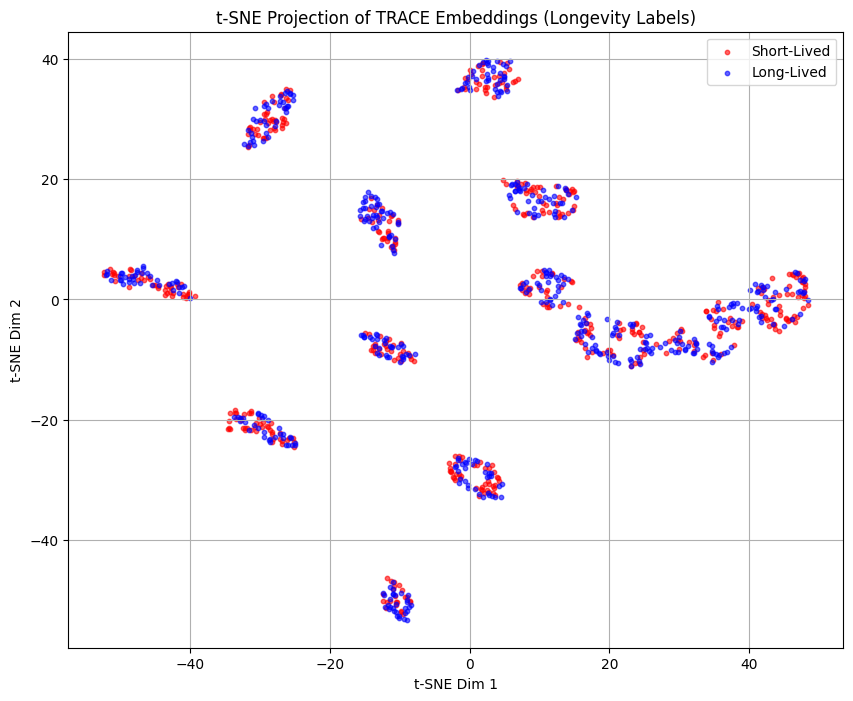

In [30]:
# ==========================
# Longevity t-SNE Visualization
# ==========================

# Step 1: Extract embeddings again if needed
embeddings, _ = extract_embeddings_and_labels(trained_model, train_loader, device=device)

# (OR reuse all_embeddings if you already have it)

# Step 2: Load Longevity Labels
longevity_labels = np.load(data_path + 'longevity_labels.npy')

# Step 3: Standardize embeddings
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

# Step 4: Plot
plt.figure(figsize=(10, 8))
for label, color, name in zip([0, 1], ['red', 'blue'], ['Short-Lived', 'Long-Lived']):
    idx = longevity_labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, label=name, alpha=0.6, s=10)

plt.title('t-SNE Projection of TRACE Embeddings (Longevity Labels)')
plt.legend()
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.grid(True)
plt.show()
